### Transfer Learning EfficientNet avec augmentation et recadrage 256x256

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.applications.efficientnet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB1
from sklearn import metrics
import tensorflow as tf


#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [7]:
data = pd.read_csv('../files_detour_256.csv',index_col=0)

In [8]:
src_img = '../images_detour_256/'

In [9]:
data['file_path'] = data['filename'].apply(lambda file :  src_img + file)

In [10]:
lst_classes = {'basophil':0,'blast':1,'eosinophil':2,
               'erythroblast':3,'ig':4,'lymphocyte':5,'monocyte':6,'neutrophil':7,'platelet':8,'smudge':9}

In [11]:
data['label'] = data['class'].apply(lambda cat: lst_classes[cat])

In [8]:
data.head()

,index,file_path,filename,class,label
0,0,../images_detour_256/BA_100102.jpg,BA_100102.jpg,basophil,0
1,1,../images_detour_256/BA_101381.jpg,BA_101381.jpg,basophil,0
2,2,../images_detour_256/BA_101611.jpg,BA_101611.jpg,basophil,0
3,3,../images_detour_256/BA_102039.jpg,BA_102039.jpg,basophil,0
4,4,../images_detour_256/BA_102750.jpg,BA_102750.jpg,basophil,0


In [28]:
data_train, data_eval = train_test_split(data,test_size=0.1,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.1,random_state=123)

#### Utilisation d'un ImageDataGenerator

In [29]:
# Recadrage de l'image
def preprocess(img):
    # img = tf.image.resize_with_crop_or_pad(img, 256, 256) # détourage déjà taille 256x256
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)  # Preprocess de EfficientNet
    return img

In [30]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess,horizontal_flip=True, vertical_flip=True,
                                    rotation_range=180
                                                       )
test_generator = ImageDataGenerator(preprocessing_function=preprocess)

In [31]:
data_train_generator = data_generator.flow_from_dataframe(data_train, directory=None, x_col='file_path',y_col='class',class_mode ='sparse',target_size=(256,256),
                                              batch_size=32)

data_test_generator = data_generator.flow_from_dataframe(data_test, directory=None, x_col='file_path',y_col='class',class_mode ='sparse',target_size=(256,256),
                                              batch_size=32)

Found 25596 validated image filenames belonging to 10 classes.
Found 2845 validated image filenames belonging to 10 classes.


#### Transfer Learning avec modèle MobileNet
* Freeze de toutes les couches
* Couches Dense 1024, 512, 256 
* Dropout pour éviter overfitting
* Compilation avec Adam avec learning_rate de 10-4

In [14]:
# Création Callback pour stopper si stagnation
callback = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)

In [2]:
# Création d'un modèle MobileNet
def model_efficientNet():
    base_model = EfficientNetB1(
        weights='imagenet',  
        input_shape=(256, 256, 3),
        include_top=False)  
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(units=1024,activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=512,activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(units=256,activation='relu')(x)
    x = Dropout(0.2)(x)
    # A Dense classifier 
    outputs = Dense(units=10,activation='softmax')(x)
    model = Model(base_model.input, outputs)


    model.compile(optimizer='adam' ,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [3]:
model = model_efficientNet()

In [17]:
#Entrainement
history = model.fit(data_train_generator, epochs = 16, validation_data = data_test_generator,callbacks=[callback])

Epoch 1/16
800/800 [==============================] - 2832s 4s/step - loss: 0.6733 - accuracy: 0.7777 - val_loss: 0.5104 - val_accuracy: 0.8323
Epoch 2/16
800/800 [==============================] - 2830s 4s/step - loss: 0.5173 - accuracy: 0.8327 - val_loss: 0.4107 - val_accuracy: 0.8675
Epoch 3/16
800/800 [==============================] - 2832s 4s/step - loss: 0.4711 - accuracy: 0.8455 - val_loss: 0.3845 - val_accuracy: 0.8794
Epoch 4/16
800/800 [==============================] - 2900s 4s/step - loss: 0.4493 - accuracy: 0.8536 - val_loss: 0.3870 - val_accuracy: 0.8777
Epoch 5/16
800/800 [==============================] - 3070s 4s/step - loss: 0.4423 - accuracy: 0.8590 - val_loss: 0.3996 - val_accuracy: 0.8791
Epoch 6/16
800/800 [==============================] - 2962s 4s/step - loss: 0.4237 - accuracy: 0.8660 - val_loss: 0.3844 - val_accuracy: 0.8770
Epoch 7/16
800/800 [==============================] - 2875s 4s/step - loss: 0.4125 - accuracy: 0.8676 - val_loss: 0.3786 - val_accuracy:

In [19]:
model.save_weights("efficientnet_10_weights_detour_augm")

#### Prédiction sur les données d'évaluation

In [4]:
model.load_weights("efficientnet_10_weights_detour_augm")

In [33]:
data_eval_generator = test_generator.flow_from_dataframe(data_eval, directory=None, x_col='file_path',y_col='class',class_mode ='sparse',target_size=(256,256),
                                              batch_size=32,shuffle=False)

Found 3161 validated image filenames belonging to 10 classes.


In [21]:
model.evaluate(data_eval_generator)

99/99 [==============================] - 303s 3s/step - loss: 0.3660 - accuracy: 0.8829


[0.3659546971321106, 0.8829484581947327]

 * Score 88% avec augmentation de données, similaire que sans augmentation et plus faible que sans détourage

#### Fine Tunning

In [26]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 256, 256, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization_1[0][0]            
_______________________________________________________________________________________

In [22]:
# Unfreeze dernier block Efficient 7b
for layer in model.layers[-26:]:
    layer.trainable = True

In [23]:
model.compile(optimizer=Adam(learning_rate=1e-4) ,loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3)

In [25]:
history = model.fit(data_train_generator, epochs = 16, validation_data = data_test_generator,callbacks=[reduce_lr,early_stopping])

Epoch 1/16
800/800 [==============================] - 3269s 4s/step - loss: 0.4245 - accuracy: 0.8642 - val_loss: 0.3303 - val_accuracy: 0.8900
Epoch 2/16
800/800 [==============================] - 3290s 4s/step - loss: 0.3563 - accuracy: 0.8852 - val_loss: 0.3093 - val_accuracy: 0.9009
Epoch 3/16
800/800 [==============================] - 3279s 4s/step - loss: 0.3334 - accuracy: 0.8906 - val_loss: 0.3270 - val_accuracy: 0.9009
Epoch 4/16
800/800 [==============================] - 3279s 4s/step - loss: 0.3135 - accuracy: 0.8948 - val_loss: 0.3026 - val_accuracy: 0.9016
Epoch 5/16
800/800 [==============================] - 3277s 4s/step - loss: 0.3057 - accuracy: 0.8972 - val_loss: 0.3034 - val_accuracy: 0.9012
Epoch 6/16
800/800 [==============================] - 3308s 4s/step - loss: 0.2960 - accuracy: 0.9022 - val_loss: 0.2844 - val_accuracy: 0.9023
Epoch 7/16
800/800 [==============================] - 3277s 4s/step - loss: 0.2894 - accuracy: 0.9041 - val_loss: 0.2887 - val_accuracy:

In [26]:
model.save_weights("efficientnet_10_weights_detour_augm")

#### Evaluation des résultats

In [27]:
model.evaluate(data_eval_generator)

99/99 [==============================] - 300s 3s/step - loss: 0.3000 - accuracy: 0.9060


[0.2999790608882904, 0.9060423970222473]

> Résultat similaire que sans augmentation de données

In [28]:
#Classes prédites
predict = model.predict(data_eval_generator)

In [29]:
eval_predict_class = predict.argmax(axis = 1)
lst_classes = [key for key, val in data_eval_generator.class_indices.items()]
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in data_eval_generator.classes]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.98      0.91      0.94       118
       blast       0.78      0.91      0.84       325
  eosinophil       0.99      0.97      0.98       320
erythroblast       0.99      0.91      0.95       217
          ig       0.86      0.78      0.82       386
  lymphocyte       0.90      0.95      0.93       467
    monocyte       0.91      0.80      0.85       264
  neutrophil       0.95      0.99      0.97       580
    platelet       0.98      1.00      0.99       231
      smudge       0.79      0.75      0.77       253

    accuracy                           0.91      3161
   macro avg       0.91      0.90      0.90      3161
weighted avg       0.91      0.91      0.91      3161



> +1% avec augmentation de données seulement
>
> amélioration sur toutes les classes et 5% sur les IG

In [30]:
pd.crosstab(pd.Series(eval_class_name, name='Réalité'),pd.Series(eval_predict_class_name, name='Prédiction'))

Prédiction,basophil,blast,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet,smudge
Réalité,,,,,,,,,,
basophil,107,0,0,0,7,1,0,1,2,0
blast,0,296,0,0,7,8,4,0,0,10
eosinophil,0,0,309,0,2,0,0,5,0,4
erythroblast,0,0,0,198,4,11,0,2,2,0
ig,0,37,0,0,303,9,11,15,0,11
lymphocyte,1,6,1,1,1,445,2,0,0,10
monocyte,0,25,0,0,5,5,212,3,0,14
neutrophil,0,0,0,0,6,0,0,574,0,0
platelet,0,0,0,0,0,0,0,0,231,0


> Confusion importante blaste/IG ainsi que monocyte/IG

In [31]:
# Récupère les cellules bien prédites => regarde la proba sur cette classe
compare = pd.DataFrame({'Réalité':data_eval['label'],'Prédiction':eval_predict_class}).reset_index()
predict_correct = compare[compare['Réalité']==compare['Prédiction']]

In [32]:
predict_by_class = []
for i in range(10):
    indexes = predict_correct[predict_correct['Réalité']==i].index
    pourcent = predict[indexes][:,i]
    predict_by_class.append(pourcent)

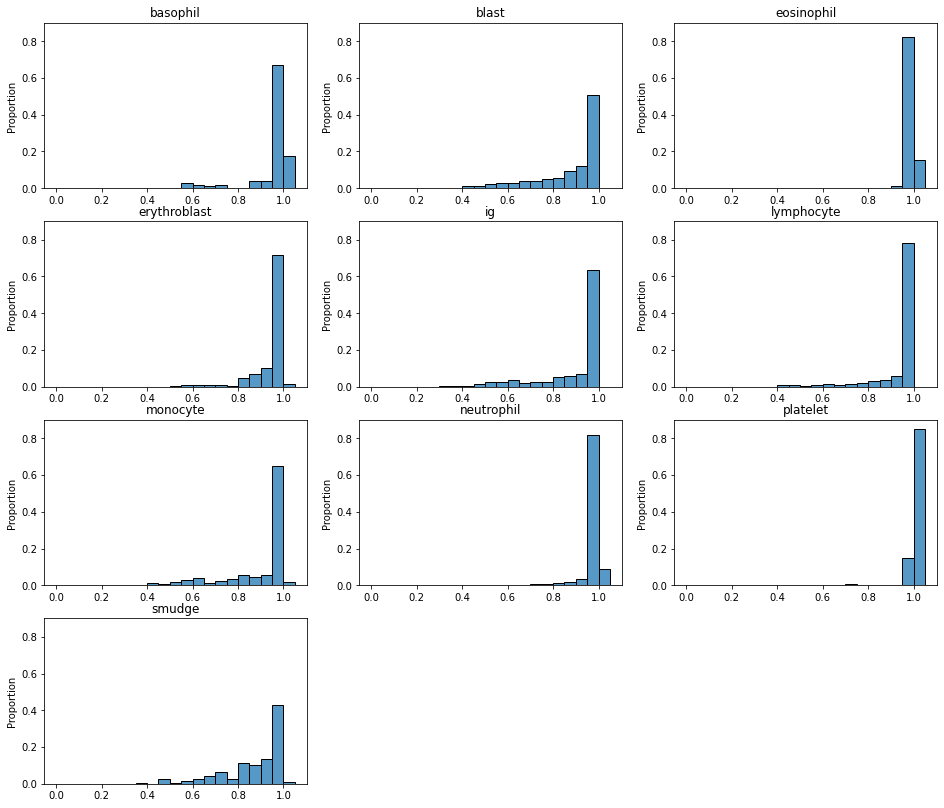

In [33]:
fig = plt.figure(figsize=(16,14))
for i in range(10):
        ax = fig.add_subplot(4, 3, i + 1)
        ax.set_ylim([0,0.9])
        plt.title(lst_classes[i])
        sns.histplot(x=predict_by_class[i],ax=ax,stat='proportion', bins = np.arange(0,1.1,0.05) )

> % similaire sans augmentation de données

In [34]:
# Cellule mal prédite => % sur la classe choisie
predict_incorrect = compare[compare['Réalité']!=compare['Prédiction']]
pourcent_incorrect = predict[predict_incorrect.index].max(axis = 1)

<AxesSubplot:ylabel='Proportion'>

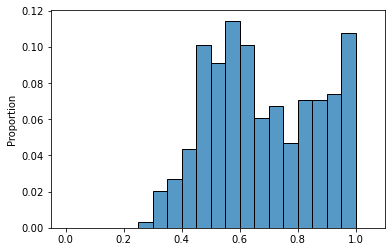

In [35]:
fig = plt.figure(figsize=(6,4))
sns.histplot(x=pourcent_incorrect,stat='proportion', bins = np.arange(0,1.1,0.05) )

> Prédiction dans la mauvaise classe avec un score souvent supérieur à 50% => ne peut pas exclure selon un taux de pourcentage


### GRAD CAM

In [13]:
import gradcam_dataset

In [14]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

block6d_expand_bn (BatchNormali (None, 8, 8, 1152)   4608        block6d_expand_conv[0][0]        
__________________________________________________________________________________________________
block6d_expand_activation (Acti (None, 8, 8, 1152)   0           block6d_expand_bn[0][0]          
__________________________________________________________________________________________________
block6d_dwconv (DepthwiseConv2D (None, 8, 8, 1152)   28800       block6d_expand_activation[0][0]  
__________________________________________________________________________________________________
block6d_bn (BatchNormalization) (None, 8, 8, 1152)   4608        block6d_dwconv[0][0]             
__________________________________________________________________________________________________
block6d_activation (Activation) (None, 8, 8, 1152)   0           block6d_bn[0][0]                 
__________________________________________________________________________________________________
block6d_se

In [15]:
img_size = (256, 256)
last_conv_layer_name = "top_conv"

In [5]:
def load_and_preprocess(img_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize_with_crop_or_pad(img, 256, 256)
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img) 
    return img

##### BASOPHIL

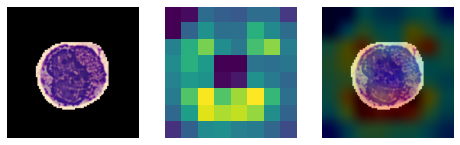

In [41]:
path = data[data['filename']=='BA_45632.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=0)

##### BLAST

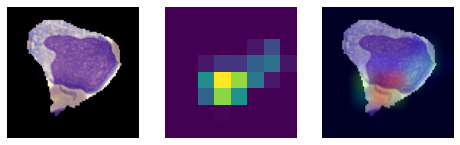

In [42]:
path = data[data['filename']=='BL_6995975.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=1)

##### EOSINOPHIL

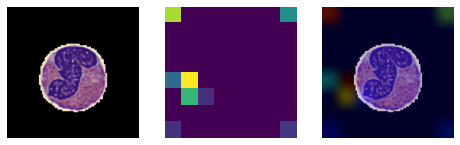

In [16]:
path = data[data['filename']=='EO_336686.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=2)

In [20]:
# Vérif si persiste des trous?
img = tf.io.read_file(path)
img = tf.io.decode_jpeg(img, channels=3)
img = tf.image.resize_with_crop_or_pad(img, 256, 256)
(img.numpy()[:50,:50,:]!=0).sum()


0

##### ERYTHROBLAST

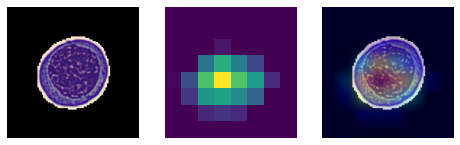

In [44]:
path = data[data['filename']=='ERB_7315.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=3)

##### IG

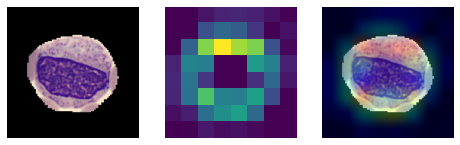

In [45]:
path = data[data['filename']=='MMY_353176.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=4)

##### LYMPHOCYTE

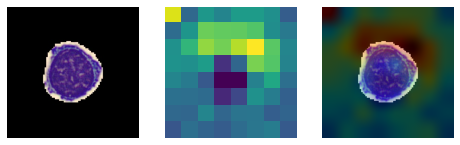

In [46]:
path = data[data['filename']=='LY_32523.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=5)

##### MONOCYTE

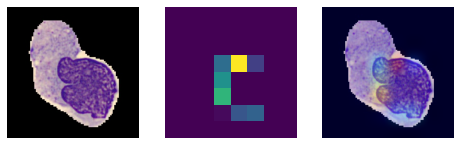

In [49]:
path = data[data['filename']=='MO_77574.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=6)

##### NEUTROPHIL

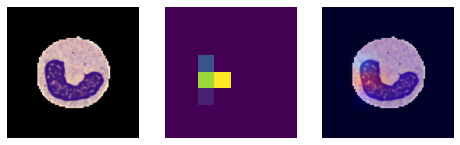

In [50]:
path = data[data['filename']=='BNE_495973.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=7)

##### PLATELET

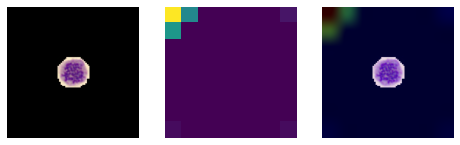

In [21]:
path = data[data['filename']=='PLATELET_77708.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=8)

In [22]:
# Vérif si persiste des trous?
img = tf.io.read_file(path)
img = tf.io.decode_jpeg(img, channels=3)
img = tf.image.resize_with_crop_or_pad(img, 256, 256)
(img.numpy()[:50,:50,:]!=0).sum()

0

##### SMUDGE

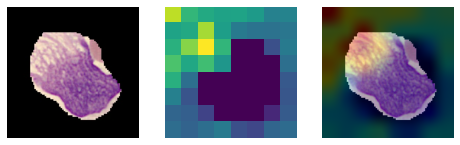

In [53]:
path = data[data['filename']=='SMU_13827002.jpg']['file_path'].values[0]
gradcam_dataset.display_headmap(load_and_preprocess, path, model, last_conv_layer_name,pred_index=9)

### EXTRACTION FEATURES

In [26]:
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('dense').output)
X_train_features = intermediate_layer_model.predict(data_train_generator)

In [34]:
X_eval_features = intermediate_layer_model.predict(data_eval_generator)

In [35]:
# Classes correspondantes
lst_classes = [key for key, val in data_train_generator.class_indices.items()]
train_class_name = [lst_classes[i] for i in data_train_generator.classes]
eval_class_name = [lst_classes[i] for i in data_eval_generator.classes]

In [36]:
from sklearn.svm import SVC
svm = SVC(C=100)

svm.fit(X_train_features, train_class_name)
svm.score(X_eval_features,eval_class_name)


0.10566276494780133